In [ ]:
import pandas as pd
import requests
import csv
import re

r = requests.get('https://www.jobfeed.nl/api/v3/search?_fields=posting_id,job_title,full_text&date__range=now-2M__now-1M&_limit=5000&job_title=senior|sr|medior|junior|jr',
                 auth=('ANONYMOUS', 'ANONYMOUS'))

results = pd.DataFrame(r.json()['results'])

def determine_seniority(title):
    seniority = ''
    if re.search(r'\b(senior|sr)\b', title, re.IGNORECASE):
        seniority = 'Senior'
    elif re.search(r'\b(medior)\b', title, re.IGNORECASE):
        seniority = 'Medior'
    elif re.search(r'\b(junior|jr)\b', title, re.IGNORECASE):
        seniority = 'Junior'
    return seniority

results['seniority_level'] = results['job_title'].apply(determine_seniority)

results[['posting_id', 'job_title', 'full_text', 'seniority_level']] \
    .to_csv('data/seniority-nl.csv', index=False, header=True, quoting=csv.QUOTE_ALL)

In [14]:
import pandas as pd

df = pd.read_csv('data/seniority-nl.csv', index_col=None)

In [20]:
df.head(n=25)

,posting_id,job_title,full_text,seniority_level
0,9772ab3e98c4440f8fe7964e0d159009,Sr. Mechanical Equipment Engineer,Sr. Mechanical Equipment Engineer - Leiden\n...,Senior
1,beff6d8161ae415c8f056d9218ccf994,(Junior) Consultant Techniek,* Zoekresultaat\n * Vacature\n\n (Junior) ...,Junior
2,01e9b62b45e24f3897ee959f8ad0c237,Senior Project Manager,Experis\n > 250 medewerkers\n Boeingavenue...,Senior
3,9b1b570dbe694881bfa7b0f39145cf1b,Junior projectleider bodemonderzoek,Junior projectleider bodemonderzoek\n\n Fun...,Junior
4,90aa084cb1894d828561ac8f11a95b32,Medior Java Developer bij Copernicus te,Medior Java Developer bij Copernicus te\n\n ...,Medior
5,ee9d46cb569d458f8730543c2c879c91,Medior werkvoorbereider (BIM),Medior werkvoorbereider (BIM)\n Bureau Vakw...,Medior
6,ccbb2c001f0448a3a3e39b8e3a94751e,Senior sales engineers,Senior sales engineers\n\n Werkgever: Lodig...,Senior
7,df7e2695c94b466b9d37bc058fe586ae,Senior Assistant Accountancy & Reporting,Senior Assistant Accountancy & Reporting\n\n...,Senior
8,6b8d5c933cfd4b12bf8a1d0b410acb12,(Junior) Accountmanager FOOD/FEED,* Zoekresultaat\n * Vacature\n\n (Junior) ...,Junior
9,c67f4fc2b3864aea95b2387546233a5e,Senior Recruiter Inhuur - overheid / Rotterdam,Senior Recruiter Inhuur - overheid / Rotterd...,Senior


In [16]:
df.shape

(16619, 4)

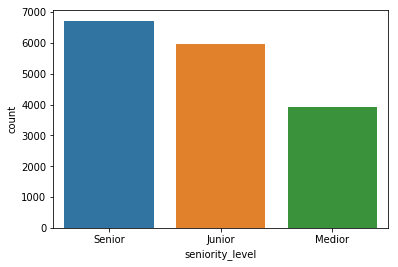

In [22]:
%matplotlib inline

import seaborn as sns

sns.countplot(x=df['seniority_level'])

In [24]:
from gensim.parsing.preprocessing import preprocess_string, RE_TAGS, strip_punctuation, stem_text, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, strip_non_alphanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from unicodedata import normalize

my_filters = [
    lambda x: x.lower(), strip_punctuation, strip_non_alphanum,
    strip_multiple_whitespaces, remove_stopwords
]

def my_tokenizer(s):
    return preprocess_string(s, filters=my_filters)

stop_words = ['junior', 'medior', 'senior']
    
vect = CountVectorizer(min_df=500, max_df=0.2, analyzer='word', tokenizer=my_tokenizer, ngram_range=(1,2),
                       stop_words=stop_words)

le = LabelEncoder()

X = vect.fit_transform(df['full_text'])
y = le.fit_transform(df['seniority_level'])

In [25]:
X.shape

(16619, 2141)

In [26]:
y.shape

(16619,)

In [30]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC

classifiers = [
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial'),
    #LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial', class_weight='balanced'),
]

for clf in classifiers:
    accs = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='accuracy')
    f1s = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='f1_macro')
    lls = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='neg_log_loss')

    print("{:>24} Accuracy: {:.2f} (+/- {:.2f}) F1: {:.2f} (+/- {:.2f}) Log loss: {:.2f} (+/- {:.2f})" \
          .format(clf.__class__.__name__, accs.mean(), accs.std(), f1s.mean(), f1s.std(), lls.mean(), lls.std()))

           MultinomialNB Accuracy: 0.60 (+/- 0.00) F1: 0.58 (+/- 0.01) Log loss: -7.82 (+/- 0.22)
      LogisticRegression Accuracy: 0.67 (+/- 0.01) F1: 0.66 (+/- 0.01) Log loss: -1.14 (+/- 0.05)


In [31]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33, stratify=y)

#clf = MultinomialNB()
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
from sklearn.metrics import classification_report

ypred = clf.predict(Xte)

print(classification_report(yte, ypred, target_names=le.classes_))

              precision    recall  f1-score   support

      Junior       0.75      0.76      0.76      1972
      Medior       0.55      0.55      0.55      1295
      Senior       0.68      0.67      0.68      2218

   micro avg       0.68      0.68      0.68      5485
   macro avg       0.66      0.66      0.66      5485
weighted avg       0.68      0.68      0.68      5485



In [33]:
le.classes_

array(['Junior', 'Medior', 'Senior'], dtype=object)

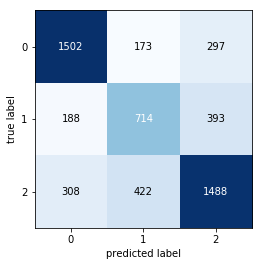

In [34]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(confusion_matrix(yte, ypred))

In [35]:
import numpy as np

feature_names = vect.get_feature_names()

for i, class_label in enumerate(le.classes_):
    top10 = np.argsort(clf.coef_[i])[-20:]
    print("%s: %s" % (class_label, ", ".join(feature_names[j] for j in top10)))
    print()

Junior: contactgegevens contactpersoon, volgen, doe je, stage, loopbaan, een belangrijke, tussen 2, starters, 2 jaar, kunt u, zojuist, 1 jaar, aangepast, search jobs, je draagt, 8 vakantiegeld, 2 years, laatst, starter, apply position

Medior: onze website, functieomschrijving, geboden, contactgegevens bedrijfsnaam, job posting, te bereiken, zo snel, doe, bereid om, woord en, geschrift, verschil, gedrag, secundaire, jobs job, minimaal 3, nl adres, bedrijfsgrootte, listed, solliciteer partner

Senior: jaar relevante, nederlandse en, aan onze, years, lezen, je naar, vaste werklocatie, focus op, kernwoorden, auto van, minimaal 3, internationaal nee, website locaties, ruime ervaring, mondeling, een prettige, volgende stap, vervaldatum, minimaal 5, 10 jaar

